## Tutorial - Training of Voronoy VGG-16 model

This tutorial demonstrates how to train a VGG-16 model and (easily created) toy-dataset Voronoy dataset (that can be used to showcase the library's functionality).



In [ ]:
# Mount Google Drive. #remove
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
#!pip install captum opencv-python torch==1.8.0 torchvision==0.9.0
#!pip install captum opencv-python torch torchvision #torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install captum opencv-python torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import warnings
import gc
import cv2
import glob
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
Looking in links: https://download.pytorch.org/whl/torch_stable.html
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Voronoy dataset.


In [ ]:
# Configs.
path = '/content/drive/MyDrive/Projects/voronoy-cells-toydata/'
nr_channels = 3
img_size = 224

class_labels = {0: "Red", 1: "Green", 2: "Blue"}

# Read png images and labels from txt file.
ds = torchvision.datasets.ImageFolder(root=path, transform=torchvision.transforms.ToTensor())
labels = [l[1] for l in np.loadtxt(path+"ds/labels.txt", delimiter=" ", skiprows=0)]

# Torchify.
labels = torch.LongTensor(labels)
images = torch.zeros(len(ds)//2, nr_channels, img_size, img_size)
masks = torch.zeros(len(ds)//2, nr_channels, img_size, img_size)

for ix, (img, mask) in enumerate(zip(torch.utils.data.Subset(ds, np.arange(0, len(ds), 2)), torch.utils.data.Subset(ds, np.arange(0, len(ds), 1)[1::2]))):
    images[ix] = img[0]
    masks[ix] = mask[0]

# Split into training and test sets.

train_images = images[:int(len(images)*0.8)]
train_masks = masks[:int(len(images)*0.8)]
train_labels = labels[:int(len(images)*0.8)]
test_images = images[int(len(images)*0.8):]
test_masks = masks[int(len(images)*0.8):]
test_labels = labels[int(len(images)*0.8):]

torch.save(test_images, "/content/drive/MyDrive/Projects/xai_quantification_toolbox/quantus/assets/test_images_voronoy")
torch.save(test_masks, "/content/drive/MyDrive/Projects/xai_quantification_toolbox/quantus/assets/test_masks_voronoy")
torch.save(test_labels, "/content/drive/MyDrive/Projects/xai_quantification_toolbox/quantus/assets/test_labels_voronoy")

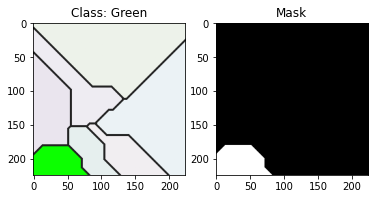

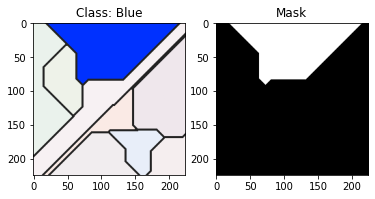

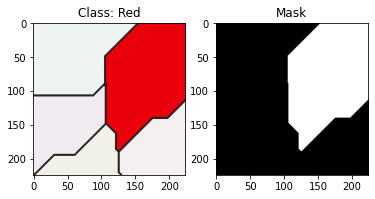

In [ ]:
def plot_example(index):
    plt.subplot(1, 2, 1)
    plt.imshow(np.moveaxis(test_images[index].numpy(), 0, -1))
    plt.title(f"Class: {class_labels[test_labels[index].item()]}")
    plt.subplot(1, 2, 2)
    plt.imshow(np.moveaxis(test_masks[index].numpy(), 0, -1))
    plt.title(f"Mask")
    plt.show()

# Plot!
[plot_example(index=i)for i in [0, 4, 5]];

### Train a VGG-16 model.

(or any other model of choice). 

In [ ]:
def train_model(model, 
                images: torchvision.datasets, 
                labels: torchvision.datasets,
                device: torch.device, 
                criterion: torch.nn, 
                optimizer: torch.optim,
                epochs: int = 20, 
                batch_size: int = 50,
                evaluate: bool = False):
    """Train torch model."""
    
    model.train()
    
    batches = np.arange(0, len(images), 50)

    for epoch in range(epochs):
        for b in batches[:-2]:
            
            optimizer.zero_grad()
            x_batch, y_batch = images[b:b+batch_size], labels[b:b+batch_size]
            logits = model(x_batch)

            loss = criterion(logits, y_batch)
            #model.zero_grad()
            loss.backward()
            optimizer.step()

            # Evaluate model!
            if evaluate:
                y_pred, y_true = evaluate_model(model, images[batches[-2]:], labels[batches[-2]:], device)
                test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
                print(f"Epoch {epoch+1}/{epochs} - train accuracy: {(100 * test_acc):.2f}%")

    return model

def evaluate_model(model, images, labels, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        logits = torch.cat([logits, model(images)])
        targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets


# Load architecture.
model = torchvision.models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = True
model.classifier[6] = torch.nn.Linear(4096, 3) # model.fc = torch.nn.Linear(512, 3)
model.eval()

path_model_weights = "drive/MyDrive/Projects/xai_quantification_toolbox/quantus/assets/voronoy_vgg16"

if pathlib.Path(path_model_weights).is_file():
    model.load_state_dict(torch.load(path_model_weights))
else:
    
    # Train and evaluate model.
    model = train_model(model=model.to(device),
                        images=train_images.to(device),
                        labels=train_labels.to(device),
                        device=device,
                        epochs=10,
                        criterion=torch.nn.CrossEntropyLoss().to(device),
                        optimizer=torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                        evaluate=True)
    
    # Save model.
    torch.save(model.state_dict(), path_model_weights)

print(f"Model loaded.")
model.eval();

# Evaluate model performance.
y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"\nModel test accuracy: {(100 * test_acc):.2f}%")

Model loaded.

Model test accuracy: 100.00%
